# Simple Implementation of Residual Quantizer and RQ-VAE

RQ-VAE (Residual-Quantized Variational Autoencoder) is a modification of VQ-VAE (Vector Quantized-Variational Autoencoder).

RQ-VAE is proposed in [this paper](https://arxiv.org/abs/2203.01941). Its official implementation is found in [the link](https://github.com/kakaobrain/rq-vae-transformer).

Here, we provide a very simple implementation of RQ-VAE and residual quantization therein.

The implmentation here is laregly based on the [colab implementation](https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=yAzAH7FIb7Tf) of VQ-VAE.

## Import Libraries

In [38]:
from __future__ import print_function

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Fix Seed

In [39]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Utils

In [40]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

## Data Load

In [41]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

/home/marti/Code/RQ-VAE/.venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


## Measure Data Variance

In [42]:
data_variance = np.var(training_data.data / 255.0)

## Define Vector Quantizer

In [43]:
def straight_through_estimator(x, c):
    # this method replaces x by c without stopping the gradient flowing through x
    return x + (c-x).detach()

def compute_perplexity(encodings):
    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
    return perplexity

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        # self._embedding.weight acts as a codebook
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.requires_grad = False
        self._embedding.weight.data.normal_()

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim), requires_grad=False)
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.detach()
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        codebook = self._embedding.weight.data
        codebook_ema = self._ema_w.data

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(codebook ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, codebook.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, codebook).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            # EMA update for codebook
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w.data = codebook_ema * self._decay + (1 - self._decay) * dw

            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Codebook update with Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                    (self._ema_cluster_size + self._epsilon)
                    / (n + self._num_embeddings * self._epsilon) * n)

            self._embedding.weight.data = self._ema_w.data / self._ema_cluster_size.unsqueeze(1)

        # convert quantized from BHWC -> BCHW
        return quantized.permute(0, 3, 1, 2).contiguous(), encodings.detach()


## Define Encoder and Decode

In [44]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                                      for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens // 2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens // 2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens // 2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens // 2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)


## Define RQ-VAE and its Residual Quantization

In [45]:
class RQVAE(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0., depth=1):
        super(RQVAE, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)

        assert decay > 0.0
        self._quantizer = VectorQuantizerEMA(num_embeddings, embedding_dim, decay)

        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

        self._commitment_cost = commitment_cost

        assert depth > 0
        self._depth = depth

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)    # additional 1x1 conv (to increase model complexity)

        '''
        start - residual quantization
        '''
        z_detached = z.detach().clone()

        _residue = z_detached
        for d in range(self._depth):
            _quantized, _ = self._quantizer(_residue)

            if d == 0:
                z_hat = _quantized
            else:
                z_hat += _quantized

            _residue = z_detached - z_hat
        '''
        end - residual quantization
        '''

        z_hat_flowing = straight_through_estimator(z, z_hat)
        x_recon = self._decoder(z_hat_flowing)

        return x_recon

    def compute_loss(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)  # additional 1x1 conv (to increase model complexity)

        '''
        start - residual quantization
        '''
        z_detached = z.detach().clone()

        _residue = z_detached
        for d in range(self._depth):
            _quantized, _encodings = self._quantizer(_residue)

            if d == 0:
                z_hat = _quantized
                _perplexity = compute_perplexity(_encodings)
                _loss_commit = F.mse_loss(z_hat.clone(), z)
            else:
                z_hat += _quantized
                _perplexity += compute_perplexity(_encodings)
                _loss_commit += F.mse_loss(z_hat.clone(), z)    # TODO: figure out why clone is required

            _residue = z_detached - z_hat

        perplexity = _perplexity / self._depth
        '''
        end - residual quantization
        '''

        z_hat_flowing = straight_through_estimator(z, z_hat)
        x_recon = self._decoder(z_hat_flowing)

        loss_commit = self._commitment_cost * _loss_commit

        return loss_commit, x_recon, perplexity

## Train Parameters

### Depth of Residual Quantizer
If `depth = 1`, it is simply a vector quantizer in the original VQ-VAE. On the other hand, if `depth > 1`, then it is a non-trivial residual quantizer.

In [46]:
depth = 4

### Other Train Parameters

In [47]:
num_workers = 4

model_name = 'rqvae_depth-%d'%depth
now_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
tb_dir_path = './logs/%s/tb_log/%s'%(model_name, now_time)

batch_size = 256
num_epochs = 10

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 256

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

## Train

In [48]:
device = torch.device("cpu")

training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=False,
                             num_workers=num_workers)

validation_loader = DataLoader(validation_data,
                               batch_size=16,
                               shuffle=True,
                               pin_memory=False,
                               num_workers=num_workers)

model = RQVAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, commitment_cost,
              decay=decay, depth=depth).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

model.train()
train_res_recon_error = []
train_res_perplexity = []

train_on = not os.path.exists('./%s.pth'%model_name)

if train_on:
    tb_writer = SummaryWriter(log_dir=tb_dir_path)
    # with torch.autograd.set_detect_anomaly(True):
    for epoch in range(num_epochs):
        model.train()

        # for (data, _) in tqdm(training_loader):
        for (data, _) in training_loader:

            data = data.to(device)
            optimizer.zero_grad()

            loss_commit, data_recon, perplexity = model.compute_loss(data)
            loss_recon = F.mse_loss(data_recon, data) / data_variance
            loss = loss_recon + loss_commit
            loss.backward()

            optimizer.step()

        print('[epoch %d] | loss_recon: %.3f, loss_commit: %.3f, perplexity %.3f'
              %(epoch, loss_recon.item(), loss_commit.item(), perplexity.item()))

        tb_writer.add_scalar('loss_recon', loss_recon.item(), epoch)
        tb_writer.add_scalar('loss_commit', loss_commit.item(), epoch)
        tb_writer.add_scalar('perplexity', perplexity.item(), epoch)

    torch.save({'model_state_dict': model.state_dict()}, './%s.pth'%model_name)

else:
    check_point = torch.load('./%s.pth'%model_name, map_location=torch.device('cpu'))
    model.load_state_dict(check_point['model_state_dict'], strict=True)


## Evaluation

In [49]:
visual_log_path ='./logs/%s/visual_log'%model_name
mkdir(visual_log_path)
(images_test, _) = next(iter(validation_loader))

### Show Original Images

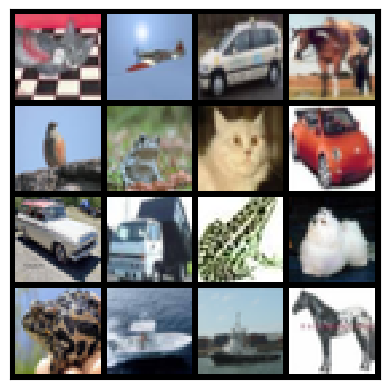

In [50]:
original_image_set = make_grid(images_test.cpu() + 0.5, nrow=4)
show(original_image_set)

### Image Reconsturction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044325948..1.145742].


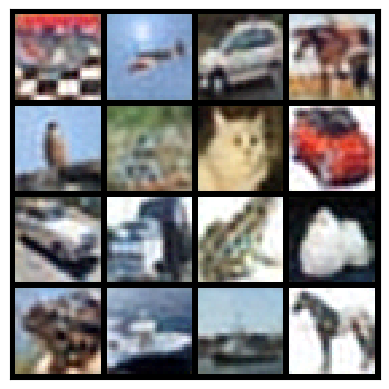

In [51]:
# image reconstruction

images_test = images_test.to(device)
reconstructed_images_test = model(images_test)

recon_image_set = make_grid(reconstructed_images_test.cpu() + 0.5, nrow=4)

show(recon_image_set)


### t-SNE Visualization of Codebook

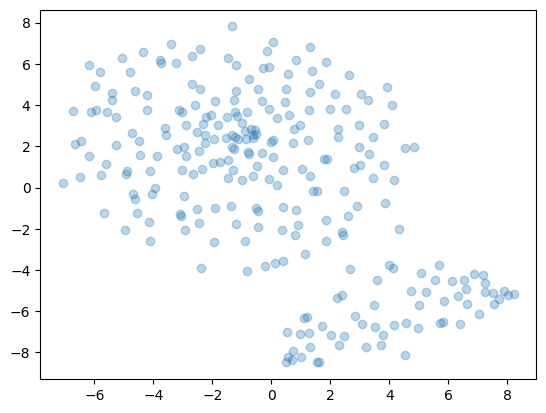

In [52]:
# tsne visualization of codebook
codebook = model._quantizer._embedding.weight.data.cpu()

proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(codebook.numpy())

plt.scatter(proj[:, 0], proj[:, 1], alpha=0.3)
